In [1]:
from numpy import copy
def banded(Aa,va,up,down):
    A = copy(Aa); v = copy(va); N = len(v)
    for m in range(N):
        div = A[up,m]
        v[m] /= div
        for k in range(1,down+1):
            if m+k<N:
                v[m+k] -= A[up+k,m]*v[m]
        for i in range(up):
            j = m + up - i
            if j<N:
                A[i,j] /= div
                for k in range(1,down+1):
                    A[i+k,j] -= A[up+k,m]*A[i,j]
    for m in range(N-2,-1,-1):
        for i in range(up):
            j = m + up - i
            if j<N:
                v[m] -= A[i,j]*v[j]
    return v

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
hbar = 1.054_571_817e-34   # J s
m_e  = 9.109_383_7015e-31  # kg

L = 1e-8        # box length (m)
N = 1000        
a = L / N      

x_full      = np.linspace(0.0, L, N+1)
x_interior  = x_full[1:-1]          
M           = N - 1                 # number of interior points

dt = 1e-18

x0    = L/2
sigma = 1e-10
kappa = 5e10  

def psi0_on_full_grid(x):
    """Unnormalized initial ψ(x,0) with Dirichlet walls at 0 and L."""
    psi = np.exp(-((x - x0)**2)/(2*sigma**2)) * np.exp(1j * kappa * x)
    psi[0]  = 0.0 + 0.0j
    psi[-1] = 0.0 + 0.0j
    return psi


alpha = 1j * hbar * dt / (4.0 * m_e * a**2)
A_diag = np.full(M, 1 + 2*alpha, dtype=np.complex128)
A_off  = np.full(M-1, -alpha,    dtype=np.complex128)
B_diag = np.full(M, 1 - 2*alpha, dtype=np.complex128)
B_off  = np.full(M-1, +alpha,    dtype=np.complex128)

def apply_B(psi_interior):
    """v = B ψ (interior-only; Dirichlet boundaries are zero)."""
    v = B_diag * psi_interior
    v[:-1] += B_off * psi_interior[1:]
    v[1:]  += B_off * psi_interior[:-1]
    return v

def assemble_A_banded_tridiag(diag, off):
    ab = np.zeros((3, M), dtype=np.complex128)
    ab[1, :]   = diag          
    ab[0, 1:]  = off           
    ab[2, :-1] = off           
    return ab

A_banded = assemble_A_banded_tridiag(A_diag, A_off)

def cn_step(psi_interior):
    rhs = apply_B(psi_interior)
    return banded(A_banded.copy(), rhs.copy(), up=1, down=1)

def to_full_grid(psi_interior):
    psi_full = np.zeros(N+1, dtype=np.complex128)
    psi_full[1:-1] = psi_interior
    return psi_full


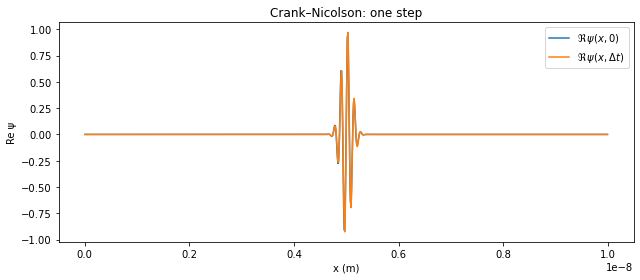

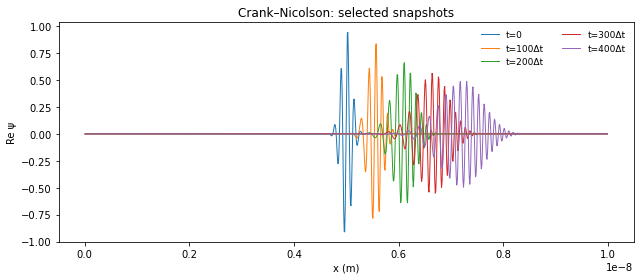

Approx ∫|ψ(x,0)|^2 dx ≈ 1.772453850905516e-10
Approx ∫|ψ(x,T)|^2 dx ≈ 1.7724538509054345e-10


In [3]:
# Part (a)
psi_full_0 = psi0_on_full_grid(x_full)
psi_int = psi_full_0[1:-1].copy()

# Single step
psi_int_1 = cn_step(psi_int)

plt.figure(figsize=(9,4))
plt.plot(x_interior, np.real(psi_int),   lw=1.5, label=r"$\Re\,\psi(x,0)$")
plt.plot(x_interior, np.real(psi_int_1), lw=1.5, label=r"$\Re\,\psi(x,\Delta t)$")
plt.xlabel("x (m)"); plt.ylabel("Re ψ")
plt.title("Crank–Nicolson: one step")
plt.legend(); plt.tight_layout(); plt.show()

# Several steps; plot a few snapshots of Re ψ
n_steps = 400
snap_every = 100
psi = psi_int.copy()
snaps = [(0, psi.copy())]
for n in range(1, n_steps+1):
    psi = cn_step(psi)
    if n % snap_every == 0:
        snaps.append((n, psi.copy()))

plt.figure(figsize=(9,4))
for n, ps in snaps:
    plt.plot(x_interior, np.real(ps), lw=1.0, label=(f"t={n}Δt" if n>0 else "t=0"))
plt.xlabel("x (m)"); plt.ylabel("Re ψ")
plt.title("Crank–Nicolson: selected snapshots")
plt.legend(ncol=2, fontsize=9, frameon=False)
plt.tight_layout(); plt.show()

# Mass check
dens0 = np.abs(psi_int)**2
densT = np.abs(psi)**2
print("Approx ∫|ψ(x,0)|^2 dx ≈", a * dens0.sum())
print("Approx ∫|ψ(x,T)|^2 dx ≈", a * densT.sum())


In [4]:
# Part (b)
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

psi_anim = psi_full_0[1:-1].copy()

frames = 300          
steps_per_frame = 5   

fig, ax = plt.subplots(figsize=(9,4))
(line,) = ax.plot(x_interior, np.real(psi_anim), lw=1.5)
ax.set_xlabel("x (m)"); ax.set_ylabel("Re ψ"); ax.set_xlim(0, L)
ymax = 1.2 * np.max(np.abs(np.real(psi_anim)))
ax.set_ylim(-ymax, ymax)
ax.set_title("Time evolution animation (Crank–Nicolson) — real part")

def update(_):
    global psi_anim
    for _ in range(steps_per_frame):
        psi_anim = cn_step(psi_anim)
    line.set_ydata(np.real(psi_anim))
    return (line,)

anim = FuncAnimation(fig, update, frames=frames, blit=True, interval=30)
plt.close(fig)  

HTML(anim.to_jshtml())


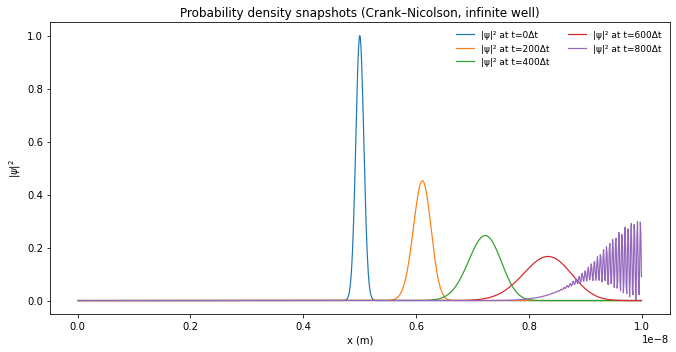

Approx ∫|ψ|^2 dx at final time ≈ 1.7724538509053518e-10


In [5]:
# Part (c)
psi_den = psi_full_0[1:-1].copy()

total_steps = 800
show_at = [0, 200, 400, 600, 800]
snapshots = {0: np.abs(psi_den)**2}

for n in range(1, total_steps+1):
    psi_den = cn_step(psi_den)
    if n in show_at:
        snapshots[n] = np.abs(psi_den)**2

plt.figure(figsize=(9.5,5))
for n in show_at:
    if n in snapshots:
        plt.plot(x_interior, snapshots[n], lw=1.2, label=f"|ψ|² at t={n}Δt")
plt.xlabel("x (m)"); plt.ylabel(r"$|\psi|^2$")
plt.title("Probability density snapshots (Crank–Nicolson, infinite well)")
plt.legend(ncol=2, fontsize=9, frameon=False)
plt.tight_layout(); plt.show()

print("Approx ∫|ψ|^2 dx at final time ≈", a * snapshots[show_at[-1]].sum())


In [12]:
import numpy as np

data_path = "particles.dat"  
xy = np.loadtxt(data_path)    

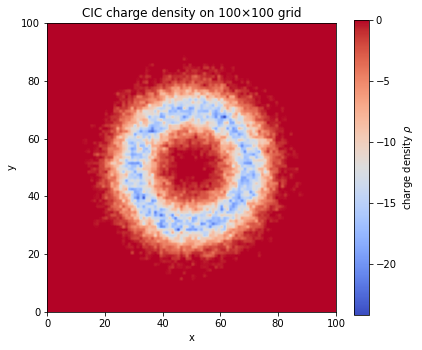

In [20]:
# Part a 
M = 100                      
L = 100.0                    
dx = L / M                   
q_particle = -1.0            # electron charge (relative units)
rho = np.zeros((M, M), float)  

# Cell centers are at (i+0.5, j+0.5). CIC: spread each charge to the 4 nearest centers.
x, y = xy[:, 0], xy[:, 1]
u = x / dx - 0.5      
v = y / dx - 0.5
i0 = np.floor(u).astype(int)
j0 = np.floor(v).astype(int)
fx = u - i0           
fy = v - j0

i0 = np.clip(i0, 0, M-2)
j0 = np.clip(j0, 0, M-2)
fx = np.clip(fx, 0.0, 1.0)
fy = np.clip(fy, 0.0, 1.0)

w00 = (1.0 - fx) * (1.0 - fy)
w10 = fx          * (1.0 - fy)
w01 = (1.0 - fx) * fy
w11 = fx          * fy

for (ii, jj, a, b, c, d) in zip(i0, j0, w00, w10, w01, w11):
    rho[ii    , jj    ] += q_particle * a
    rho[ii + 1, jj    ] += q_particle * b
    rho[ii    , jj + 1] += q_particle * c
    rho[ii + 1, jj + 1] += q_particle * d


plt.figure(figsize=(6,5))
im = plt.imshow(rho.T, origin="lower", extent=[0, L, 0, L], cmap="coolwarm")
plt.colorbar(im, label=r"charge density $\rho$")
plt.title("CIC charge density on 100×100 grid")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout(); plt.show()


(b) Jacobi converged in 47063 iterations; max change < 1e-10


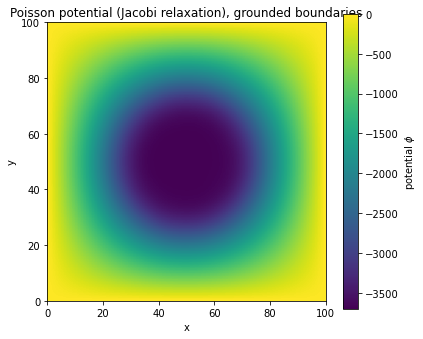

In [21]:
# Part b
eps0 = 1.0                
rhs = -rho / eps0           
tol = 1e-10

phi = np.zeros((M, M), float)
phi_new = np.zeros_like(phi)

def jacobi_step(phi, rhs, dx):
    interior = (slice(1, -1), slice(1, -1))
    phi_new = phi.copy()
    phi_new[interior] = 0.25 * (
        phi[2:  , 1:-1] + phi[ :-2, 1:-1] +
        phi[1:-1, 2:  ] + phi[1:-1,  :-2] -
        (dx*dx) * rhs[1:-1, 1:-1]
    )
    return phi_new

iters = 0
while True:
    iters += 1
    phi_new = jacobi_step(phi, rhs, dx)
    diff_max = np.max(np.abs(phi_new - phi))
    phi[:] = phi_new
    if diff_max < tol:
        break

print(f"(b) Jacobi converged in {iters} iterations; max change < {tol:g}")

plt.figure(figsize=(6,5))
im = plt.imshow(phi.T, origin="lower", extent=[0, L, 0, L], cmap="viridis")
plt.colorbar(im, label=r"potential $\phi$")
plt.title("Poisson potential (Jacobi relaxation), grounded boundaries")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout(); plt.show()


(c) Optimal ω ≈ 1.940 with 454 iterations to converge


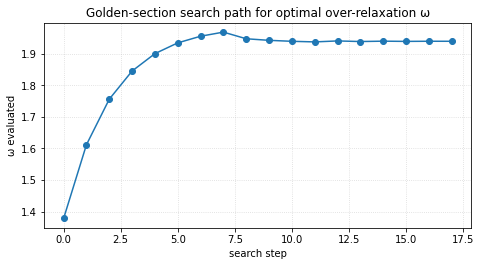

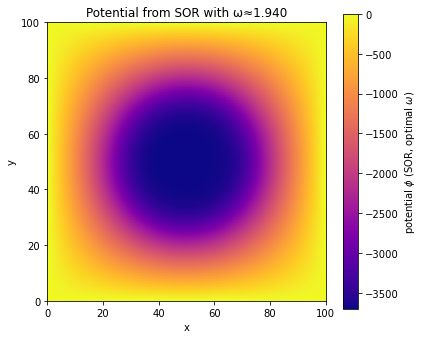

In [22]:
# Part c - over/under relaxation

I, J = np.meshgrid(np.arange(M), np.arange(M), indexing="ij")
mask_in = (I>=1) & (I<=M-2) & (J>=1) & (J<=M-2)
mask_red  = mask_in & ((I + J) % 2 == 0)
mask_black= mask_in & ((I + J) % 2 == 1)

def sor_iterations_for_omega(omega, max_iters=2_000_000):
    phi = np.zeros((M, M), float)
    it = 0
    while True:
        it += 1
        phi_old = phi.copy()

        nb_sum = (
            np.roll(phi, +1, axis=0) + np.roll(phi, -1, axis=0) +
            np.roll(phi, +1, axis=1) + np.roll(phi, -1, axis=1)
        )
        nb_sum[0, :]    -= np.roll(phi, +1, axis=0)[0, :]
        nb_sum[-1, :]   -= np.roll(phi, -1, axis=0)[-1, :]
        nb_sum[:, 0]    -= np.roll(phi, +1, axis=1)[:, 0]
        nb_sum[:, -1]   -= np.roll(phi, -1, axis=1)[:, -1]

        phi[mask_red] = (1.0 - omega) * phi[mask_red] + \
                        0.25 * omega * (nb_sum[mask_red] - (dx*dx) * rhs[mask_red])

        nb_sum = (
            np.roll(phi, +1, axis=0) + np.roll(phi, -1, axis=0) +
            np.roll(phi, +1, axis=1) + np.roll(phi, -1, axis=1)
        )
        nb_sum[0, :]    -= np.roll(phi, +1, axis=0)[0, :]
        nb_sum[-1, :]   -= np.roll(phi, -1, axis=0)[-1, :]
        nb_sum[:, 0]    -= np.roll(phi, +1, axis=1)[:, 0]
        nb_sum[:, -1]   -= np.roll(phi, -1, axis=1)[:, -1]

        phi[mask_black] = (1.0 - omega) * phi[mask_black] + \
                          0.25 * omega * (nb_sum[mask_black] - (dx*dx) * rhs[mask_black])

        diff_max = np.max(np.abs(phi - phi_old))
        if diff_max < tol:
            return it
        if it >= max_iters:
            return np.inf  # treat as failure

def golden_section_search(f, a=1.0, b=1.99, tol_omega=1e-3):
    """Minimize f(ω) on [a,b] using golden-section search; record ω path."""
    gr = (np.sqrt(5.0) - 1.0) / 2.0
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = f(c); fd = f(d)
    history = [(c, fc), (d, fd)]
    while abs(b - a) > tol_omega:
        if fc <= fd:
            b, d, fd = d, c, fc
            c = b - gr * (b - a)
            fc = f(c)
            history.append((c, fc))
        else:
            a, c, fc = c, d, fd
            d = a + gr * (b - a)
            fd = f(d)
            history.append((d, fd))
    omega_star = 0.5 * (a + b)
    iters_star = f(omega_star)
    history.append((omega_star, iters_star))
    return omega_star, iters_star, history

omega_opt, iters_opt, hist = golden_section_search(sor_iterations_for_omega,
                                                   a=1.0, b=1.99, tol_omega=1e-3)
print(f"(c) Optimal ω ≈ {omega_opt:.3f} with {iters_opt:d} iterations to converge")

ws  = [w for (w, it) in hist]
its = [it for (w, it) in hist]

fig, ax1 = plt.subplots(figsize=(6.8, 3.8))
ax1.plot(ws, "o-", lw=1.5)
ax1.set_xlabel("search step")
ax1.set_ylabel("ω evaluated")
ax1.set_title("Golden-section search path for optimal over-relaxation ω")
ax1.grid(True, ls=":", alpha=0.5)
plt.tight_layout(); plt.show()


phi_sor = np.zeros((M, M), float)
_ = sor_iterations_for_omega(omega_opt)  
def solve_sor(omega):
    phi = np.zeros((M, M), float)
    while True:
        phi_old = phi.copy()
        nb_sum = (
            np.roll(phi, +1, axis=0) + np.roll(phi, -1, axis=0) +
            np.roll(phi, +1, axis=1) + np.roll(phi, -1, axis=1)
        )
        nb_sum[0, :]    -= np.roll(phi, +1, axis=0)[0, :]
        nb_sum[-1, :]   -= np.roll(phi, -1, axis=0)[-1, :]
        nb_sum[:, 0]    -= np.roll(phi, +1, axis=1)[:, 0]
        nb_sum[:, -1]   -= np.roll(phi, -1, axis=1)[:, -1]
        phi[mask_red] = (1-omega)*phi[mask_red] + 0.25*omega*(nb_sum[mask_red] - (dx*dx)*rhs[mask_red])

        nb_sum = (
            np.roll(phi, +1, axis=0) + np.roll(phi, -1, axis=0) +
            np.roll(phi, +1, axis=1) + np.roll(phi, -1, axis=1)
        )
        nb_sum[0, :]    -= np.roll(phi, +1, axis=0)[0, :]
        nb_sum[-1, :]   -= np.roll(phi, -1, axis=0)[-1, :]
        nb_sum[:, 0]    -= np.roll(phi, +1, axis=1)[:, 0]
        nb_sum[:, -1]   -= np.roll(phi, -1, axis=1)[:, -1]
        phi[mask_black] = (1-omega)*phi[mask_black] + 0.25*omega*(nb_sum[mask_black] - (dx*dx)*rhs[mask_black])

        if np.max(np.abs(phi - phi_old)) < tol:
            return phi

phi_sor = solve_sor(omega_opt)

plt.figure(figsize=(6,5))
im = plt.imshow(phi_sor.T, origin="lower", extent=[0, L, 0, L], cmap="plasma")
plt.colorbar(im, label=r"potential $\phi$ (SOR, optimal $\omega$)")
plt.title(f"Potential from SOR with ω≈{omega_opt:.3f}")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout(); plt.show()
